## **Evaluation of Lyrics, Audio, and Hybrid Similarity Spaces**

This notebook focuses on assessing how the three similarity spaces;lyrics, audio, and hybrid—behave under different analytical views. It introduces metrics, visualizations, and comparative tables that reveal how retrieval patterns shift across modalities and α-weightings. The goal is to quantify the strengths and trade-offs of each representation, enabling a clearer understanding of when multimodal similarity outperforms single-modality approaches.

In [4]:
!pip install faiss-cpu
import pandas as pd
import numpy as np
import faiss
import joblib

# 1. Load dataset with track_id
df = pd.read_csv("/content/spotify_20k_with_ids.csv")

# 2. Load lyric + audio embeddings
lyrics_emb = np.load("/content/lyrics_embeddings.npy")
audio_emb = np.load("/content/audio_embeddings.npy")

# 3. Load FAISS indices
lyrics_index = faiss.read_index("/content/lyrics_index.faiss")
audio_index = faiss.read_index("/content/audio_index.faiss")

Defines a lyric-based nearest-neighbor function that queries the FAISS index using the seed track’s embedding. It retrieves the top matches, filters out the seed track itself, and returns the neighbor indices along with their similarity scores.

In [5]:
def get_lyrics_neighbors(seed_idx, embeddings, index, k=10):
    query = embeddings[seed_idx:seed_idx+1]     # shape (1, D)
    scores, idxs = index.search(query, k+1)     # includes self
    scores = scores[0]
    idxs = idxs[0]

    # remove self
    mask = idxs != seed_idx
    idxs = idxs[mask][:k]
    scores = scores[mask][:k]

    return idxs, scores

Implements the audio-based nearest-neighbor lookup by querying the FAISS audio index with the seed track’s audio embedding. After retrieving the top results, it removes the seed item itself and returns the closest audio-similar neighbors along with their similarity scores.


In [6]:
def get_audio_neighbors(seed_idx, audio_embeddings, audio_index, k=10):
    query = audio_embeddings[seed_idx:seed_idx+1]
    scores, idxs = audio_index.search(query, k+1)
    scores = scores[0]
    idxs = idxs[0]

    mask = idxs != seed_idx
    idxs = idxs[mask][:k]
    scores = scores[mask][:k]

    return idxs, scores

Defines the core utilities for hybrid similarity comparison. norm01 rescales any score vector to the
0
,
1
range, compute_cosine_scores calculates cosine similarities via dot products using normalized embeddings, and get_hybrid_neighbors blends lyric and audio similarity according to the chosen α value. The function then ranks all tracks by hybrid score, removes the seed item, and returns the top-k most similar neighbors.

In [7]:
def norm01(x):
    x_min, x_max = x.min(), x.max()
    return (x - x_min) / (x_max - x_min + 1e-9)

def compute_cosine_scores(seed_idx, matrix):
    query = matrix[seed_idx:seed_idx+1]         # (1, D)
    scores = matrix @ query.T                  # dot product = cosine
    return scores.ravel()

def get_hybrid_neighbors(seed_idx, lyrics_emb, audio_emb, alpha=0.5, k=10):
    # compute cosine similarities
    lyr_scores = compute_cosine_scores(seed_idx, lyrics_emb)
    aud_scores = compute_cosine_scores(seed_idx, audio_emb)

    # normalize to [0,1] for balance
    lyr_scores_n = norm01(lyr_scores)
    aud_scores_n = norm01(aud_scores)

    # hybrid score
    hybrid_scores = alpha * aud_scores_n + (1 - alpha) * lyr_scores_n

    # sort top results
    idxs = np.argsort(-hybrid_scores)
    idxs = idxs[idxs != seed_idx]        # remove self
    top_idxs = idxs[:k]
    top_scores = hybrid_scores[top_idxs]

    return top_idxs, top_scores

Creates a unified recommendation interface that can return lyric-based, audio-based, or hybrid neighbors depending on the selected mode. The function retrieves the appropriate similarity scores, extracts the seed track and its recommended matches, and packages the results into clean tables for inspection.

In [19]:
def recommend(seed_idx, mode="hybrid", k=10, alpha=0.5):
    if mode == "lyrics":
        idxs, scores = get_lyrics_neighbors(seed_idx, lyrics_emb, lyrics_index, k)
    elif mode == "audio":
        idxs, scores = get_audio_neighbors(seed_idx, audio_emb, audio_index, k)
    else:
        idxs, scores = get_hybrid_neighbors(seed_idx, lyrics_emb, audio_emb, alpha, k)

    seed = df.iloc[[seed_idx]][["Artist(s)", "song", "text"]]
    recs = df.iloc[idxs][["Artist(s)", "song", "text"]]
    recs = recs.assign(score=scores)

    return seed, recs

Runs a hybrid recommendation query for the selected seed track using the specified α weighting. The cell then displays the seed song followed by its top recommended neighbors, letting you inspect how the hybrid similarity model ranks related tracks.

In [20]:
seed, recs = recommend(123, mode="hybrid", k=10, alpha=0.4)
seed
recs

,Artist(s),song,text,score
888,Bullet For My Valentine,Welcome Home Sanitarium,[Verse 1] Welcome to where time stands still N...,0.650318
33,Emperor,With Strength I Burn,Deep Green Dark Chaos Blinded I run down these...,0.645183
216,Northlane,Talking Heads,[Verse 1] Tiptoe through the ruins of my mind ...,0.640158
475,Immortal,Unholy Forces of Evil,[Verse 1] Slowly crossing as red rivers run be...,0.634365
267,Suicide Silence,Two Steps,[Intro] I'm two steps away So why don't you ki...,0.627295
865,Slipknot,Skin Ticket,[Verse 1] Zero and zero is nothing but zero Ca...,0.623653
667,Blacklistt,Pinworm,"[Verse 1: Ghostemane] Mission perfect, react, ...",0.621837
175,Killswitch Engage,This Is Goodbye,[Intro] (This is my goodbye) (This is my goodb...,0.620122
31,Anthony Lo Re,Ultimate Battle - Ka Ka Kachi Daze From Dragon...,[Chorus] (Ka Ka Ka Ka) Time to end this (Gun G...,0.619527
574,"Beach Vacation,Cathedral Bells",Coping,"[Verse 1] Primal, evil, what am I? Tongue-tied...",0.618809


Defines a simple Purity@K metric that measures how many of the retrieved neighbors share the same categorical label as the seed track (e.g., genre, emotion). The function handles missing labels, compares each neighbor’s label to the seed’s label, and returns the proportion of matching items, giving a quick measure of retrieval consistency.

In [21]:
# Purity@K for a label column

def purity_at_k(seed_idx, neighbor_idxs, label_col):
    """
    Proportion of neighbors that share the same label as the seed.
    """
    if label_col not in df.columns:
        raise ValueError(f"{label_col} not in dataframe")

    seed_label = df.loc[seed_idx, label_col]
    if pd.isna(seed_label):
        return np.nan

    neighbor_labels = df.loc[neighbor_idxs, label_col]
    valid = neighbor_labels.notna()
    if valid.sum() == 0:
        return np.nan

    matches = (neighbor_labels[valid] == seed_label).mean()
    return matches

Computes an artist diversity metric by checking how many distinct artists appear among the retrieved neighbors. It returns the fraction of unique artists within the top-K results, offering a simple way to assess how varied or repetitive the recommendations are.

In [22]:
def artist_diversity_at_k(neighbor_idxs):
    if "artist" not in df.columns:
        return np.nan
    artists = df.loc[neighbor_idxs, "artist"].dropna()
    if len(artists) == 0:
        return np.nan
    return artists.nunique() / len(artists)

Implements an evaluation helper that computes multiple metrics for a single seed track across any similarity mode. It retrieves the appropriate neighbors, then calculates Purity@K for selected label columns and adds an artist-diversity score. The function returns a compact dictionary of metrics, making it easy to compare how lyrics, audio, and hybrid retrieval behave.

In [23]:
def evaluate_seed(seed_idx, mode="lyrics", k=10, alpha=0.5, label_cols=None):
    if label_cols is None:
        label_cols = []

    if mode == "lyrics":
        neighbor_idxs, _ = get_lyrics_neighbors(seed_idx, lyrics_emb, lyrics_index, k)
    elif mode == "audio":
        neighbor_idxs, _ = get_audio_neighbors(seed_idx, audio_emb, audio_index, k)
    else:
        neighbor_idxs, _ = get_hybrid_neighbors(seed_idx, lyrics_emb, audio_emb, alpha, k)

    metrics = {}
    for col in label_cols:
        metrics[f"{col}_purity@{k}"] = purity_at_k(seed_idx, neighbor_idxs, col)

    metrics[f"artist_diversity@{k}"] = artist_diversity_at_k(neighbor_idxs)
    return metrics

Identifies which label columns (such as genre or emotion) are available in the dataset and selects them for evaluation. This ensures the later metrics only run on labels that actually exist in the current DataFrame.

In [24]:
# Decide which label columns you actually have
label_cols = []
if "genre" in df.columns:
    label_cols.append("genre")
if "emotion" in df.columns:
    label_cols.append("emotion")

print("Using label columns:", label_cols)

Using label columns: ['emotion']


Runs a comparative evaluation across 200 randomly selected seed tracks, testing lyric-only, audio-only, and hybrid retrieval for each one. For every seed–mode pair, the code computes the selected metrics (Purity@K, artist diversity, etc.) and stores the results in a list. The final DataFrame provides an aggregated view of how each similarity mode performs, enabling later analysis and plotting.

In [26]:
import random

N_SEEDS = 200      # number of random seeds to evaluate
K = 10
ALPHA_HYBRID = 0.4

all_indices = df.index.to_list()
seed_indices = random.sample(all_indices, N_SEEDS)

results = []

for seed_idx in seed_indices:
    for mode in ["lyrics", "audio", "hybrid"]:
        metrics = evaluate_seed(
            seed_idx,
            mode=mode,
            k=K,
            alpha=ALPHA_HYBRID,
            label_cols=label_cols
        )
        metrics["seed_idx"] = seed_idx
        metrics["mode"] = mode
        results.append(metrics)

results_df = pd.DataFrame(results)
results_df.head()

,emotion_purity@10,artist_diversity@10,seed_idx,mode
0,0.2,NaN,723,lyrics
1,0.0,NaN,723,audio
2,0.1,NaN,723,hybrid
3,0.3,NaN,420,lyrics
4,0.4,NaN,420,audio


Aggregates the evaluation metrics by retrieval mode (lyrics, audio, hybrid) and computes the mean and standard deviation for each metric. This summary makes it easy to compare overall performance and variability across the three similarity spaces.

In [27]:
agg = results_df.groupby("mode").agg(["mean", "std"])
agg

emotion_purity@10           artist_diversity@10     seed_idx           
                    mean       std                mean std     mean        std
mode                                                                          
audio             0.2915  0.183428                 NaN NaN    486.9  284.72134
hybrid            0.3285  0.210617                 NaN NaN    486.9  284.72134
lyrics            0.3245  0.197089                 NaN NaN    486.9  284.72134

Checks whether genre-purity results are available and, if so, computes the average Genre Purity@K for each retrieval mode. It then plots these averages as a bar chart, giving a quick visual comparison of how well lyrics, audio, and hybrid similarity preserve genre consistency.

In [32]:
import matplotlib.pyplot as plt

if f"genre_purity@{K}" in results_df.columns:
    gp = results_df.groupby("mode")[f"genre_purity@{K}"].mean()

    plt.figure()
    gp.plot(kind="bar")
    plt.ylabel(f"Genre Purity@{K}")
    plt.title(f"Genre Purity@{K} by Mode")
    plt.show()

Calculates the average Emotion Purity@K for each retrieval mode if the metric exists and visualizes the results as a bar chart. This provides a quick comparison of how well lyrics, audio, and hybrid similarity preserve emotional consistency in their top-K recommendations.

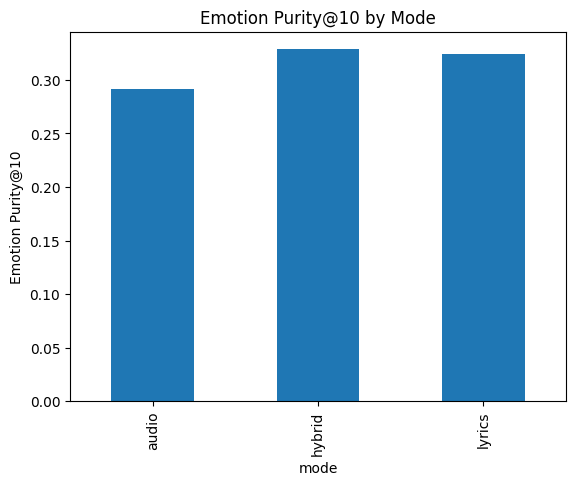

In [33]:
import matplotlib.pyplot as plt

if f"emotion_purity@{K}" in results_df.columns:
    ep = results_df.groupby("mode")[f"emotion_purity@{K}"].mean()

    plt.figure()
    ep.plot(kind="bar")
    plt.ylabel(f"Emotion Purity@{K}")
    plt.title(f"Emotion Purity@{K} by Mode")
    plt.show()

Computes the average artist-diversity score for each retrieval mode and visualizes the results in a bar chart. This comparison helps reveal how widely each similarity method spreads recommendations across different artists.

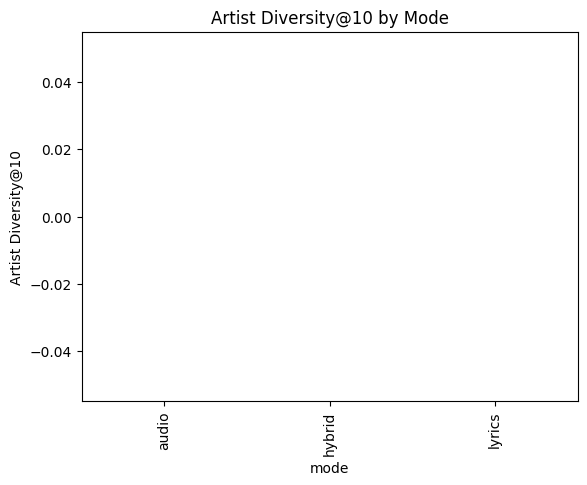

In [34]:
ad = results_df.groupby("mode")[f"artist_diversity@{K}"].mean()

plt.figure()
ad.plot(kind="bar")
plt.ylabel(f"Artist Diversity@{K}")
plt.title(f"Artist Diversity@{K} by Mode")
plt.show()

## QUALITATIVE EXAMPLE

Randomly selects one of the evaluation seed tracks and displays its artist, title, and lyrics. This provides a concrete reference point for examining how different retrieval modes behave for that specific song.

In [36]:
SEED_IDX = random.choice(seed_indices)
seed_row = df.loc[SEED_IDX, ["Artist(s)", "song", "text"]]
seed_row

,791
Artist(s),Isaac Hong
song,Kiss me Kiss me
text,Baby I'm out on midnight cruise With my open h...


Generates side-by-side recommendations for the selected seed track using lyric-only, audio-only, and hybrid similarity modes. The seed song is displayed first, followed by each set of neighbors, allowing you to visually compare how the different representation spaces influence retrieval behavior and how the hybrid model blends the two modalities.

In [38]:
seed, recs_lyrics = recommend(SEED_IDX, mode="lyrics", k=10)
_, recs_audio = recommend(SEED_IDX, mode="audio", k=10)
_, recs_hybrid = recommend(SEED_IDX, mode="hybrid", k=10, alpha=ALPHA_HYBRID)

display(seed[["Artist(s)", "song", "text"]])

print("\nLyrics-space neighbors:")
display(recs_lyrics[["Artist(s)", "song", "text"]])

print("\nAudio-space neighbors:")
display(recs_audio[["Artist(s)", "song", "text"]])

print("\nHybrid-space neighbors:")
display(recs_hybrid[["Artist(s)", "song", "text", "score"]])

,Artist(s),song,text
791,Isaac Hong,Kiss me Kiss me,Baby I'm out on midnight cruise With my open h...



Lyrics-space neighbors:


,Artist(s),song,text
367,DJ BoBo,Dont Break My Heart,Don't break my heart Don't leave me alone I'm ...
571,Ché-Fu,I Dont Wanna Miss A Thing,I could stay awake just to hear you breathing ...
995,Air Supply,After All,Night- And the world is fast asleep I wi...
746,Tracy Chapman,A Hundred Years,Baby sweet baby Won't you please Come on back ...
527,Ro James,A.D.I.D.A.S All Day I,[Verse 1] I see your face when I Close my eyes...
589,Adam Ragsdale,Blvd,"[Verse 1] I remember when we were just kids, r..."
864,DUCIPAO,TAEYEON - HORIZON English Translation,"A seaside highway, open the window My messy ha..."
874,Michael W. Smith,Hey Love,[Verse 1] Now everything is still The bedlam A...
872,Adrian Marcel,Spending The Night Alone,(Turn the lights off) [Verse 1] Those kisses ...
58,James TW,Incredible,[Verse 1] You’re wearing that dress I like Tho...



Audio-space neighbors:


,Artist(s),song,text
520,Dijon,Nintendo 64,[Verse 1] My dog just ran away and I am feelin...
479,"Calvin Harris,Frank Ocean,Migos,Funk Wav",Official Tissue,"[Intro] Ayy, let me hear that ho, Jeff DJ Dure..."
239,"Brett Eldredge,Meghan Trainor",Baby It's Cold Outside,I really can't stay - Baby it's cold outside ...
666,Albion Place,Ill Forgive You Even If You Die,On the roof of the final train Fragments of me...
427,Picture This,Life In Colour,[Verse 1] I don't ever wanna spend another sec...
348,"Durand Jones & The Indications,Durand Jones,Aa...",Never Heard Em Say,[Verse 1] I don't wanna be just another silly ...
223,MAMAMOO,MAMAMOO - Good Night English Translation,"[Verse 1: Wheein, Hwasa, Solar] When the sound..."
284,Cal Scruby,Blink 182,[Intro] Look what you made me do [Verse 1] Ok...
384,Vera,Antananarivo,All the souls in the nighttime Fly around like...
940,"bLAck pARty,Gwen Bunn",Soakin,"[Intro: ​bLAck pARty & Gwen Bunn] Yeah, uh-huh..."



Hybrid-space neighbors:


,Artist(s),song,text,score
367,DJ BoBo,Dont Break My Heart,Don't break my heart Don't leave me alone I'm ...,0.711047
571,Ché-Fu,I Dont Wanna Miss A Thing,I could stay awake just to hear you breathing ...,0.670737
746,Tracy Chapman,A Hundred Years,Baby sweet baby Won't you please Come on back ...,0.662153
348,"Durand Jones & The Indications,Durand Jones,Aa...",Never Heard Em Say,[Verse 1] I don't wanna be just another silly ...,0.661410
223,MAMAMOO,MAMAMOO - Good Night English Translation,"[Verse 1: Wheein, Hwasa, Solar] When the sound...",0.656142
427,Picture This,Life In Colour,[Verse 1] I don't ever wanna spend another sec...,0.651457
640,L.A.B.,Give Love A Try,"[Verse 1] You, you're like driving on a Sunday...",0.648048
239,"Brett Eldredge,Meghan Trainor",Baby It's Cold Outside,I really can't stay - Baby it's cold outside ...,0.638758
79,Maxi Priest,Holiday,[Verse] I didn’t think you’d be...more than a ...,0.632133
422,Uncle Kracker,What You Lookin At,747 11 come to bust Somebody take me home I...,0.629882
